In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
stock_news_data = pd.read_csv("AAPL_data.csv")
nan_counts = stock_news_data.isna().sum()
print(nan_counts)
stock_news_data['5-Moving Average'] = stock_news_data['Adj Close'].rolling(window=5).mean()
stock_news_data['20-Moving Average'] = stock_news_data['Adj Close'].rolling(window=20).mean()
stock_news_data['Sentiment 5-Moving Average'] = stock_news_data['headline_score'].rolling(window=5).mean()
stock_news_data['Sentiment 20-Moving Average'] = stock_news_data['headline_score'].rolling(window=20).mean()
stock_news_data = stock_news_data.dropna()

Date                0
Open                0
High                0
Low                 0
Adj Close           0
Volume              0
Prev Day            1
Target              0
Adj Close Change    1
headline_score      0
dtype: int64


In [3]:
# Assume df is your DataFrame
scaler = MinMaxScaler()
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'headline_score', '5-Moving Average','20-Moving Average', 'Sentiment 5-Moving Average','Sentiment 20-Moving Average']
close = stock_news_data[['Adj Close']].copy()
stock_news_data[features] = scaler.fit_transform(stock_news_data[features])

# Function to create windows of time-series data
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size):
        windows.append(data[i:i+window_size])
    return np.array(windows)

window_size = 3
X = create_windows(stock_news_data[features].values, window_size)
y = stock_news_data['Target'].values[window_size:]
print(X.shape)
print(y.shape)


(228, 3, 10)
(228,)


In [4]:
split_ratio = 0.7
split_point = int(len(X) * split_ratio)

# Split the data into training and testing sets
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

In [6]:
model = Sequential()
# Convolutional layer that will process each window
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(window_size, len(features))))
#model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model = Sequential([
#     LSTM(64, activation='tanh', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
#     LSTM(32, activation='tanh', return_sequences=True,),
#     LSTM(32, activation='tanh', return_sequences=True),
#     LSTM(32, activation='tanh', return_sequences=True),
#     LSTM(32, activation='tanh', return_sequences=True),
#     LSTM(32, activation='tanh',),
#     Dense(1)
# ])
# model.compile(optimizer='adam', loss='mse')


In [7]:
#batch size
#batch_size= int(len(X_train)/3)

early_stopping = EarlyStopping(monitor='accuracy',
                               patience=500,         # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)  # Restores model weights from the epoch with the best value of the monitored quantity.

# Train with early stopping and a validation split
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

#model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)
predictions = model.predict(X_test)

Epoch 1/100
5/5 [==============================] - 4s 187ms/step - loss: 0.6941 - accuracy: 0.4340 - val_loss: 0.6938 - val_accuracy: 0.4493
Epoch 2/100
5/5 [==============================] - 0s 9ms/step - loss: 0.6935 - accuracy: 0.4717 - val_loss: 0.6936 - val_accuracy: 0.4493
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 0.6933 - accuracy: 0.4717 - val_loss: 0.6934 - val_accuracy: 0.4493
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 0.6931 - accuracy: 0.4717 - val_loss: 0.6932 - val_accuracy: 0.4493
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5786 - val_loss: 0.6929 - val_accuracy: 0.5507
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 0.6929 - accuracy: 0.5283 - val_loss: 0.6927 - val_accuracy: 0.5507
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 0.6928 - accuracy: 0.5283 - val_loss: 0.6925 - val_accuracy: 0.5507
Epoch 8/100
5/5 [========

In [35]:
predictions = predictions.reshape(-1)
print(y_test)
print(predictions.shape)

[1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1
 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1]
(69,)


In [33]:
binary_predictions = (predictions > 0.27).astype(int)
print(binary_predictions)

[1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [34]:
accuracy = np.mean(y_test == binary_predictions)

print(f'Directional Accuracy: {accuracy:.2%}')

Directional Accuracy: 57.97%


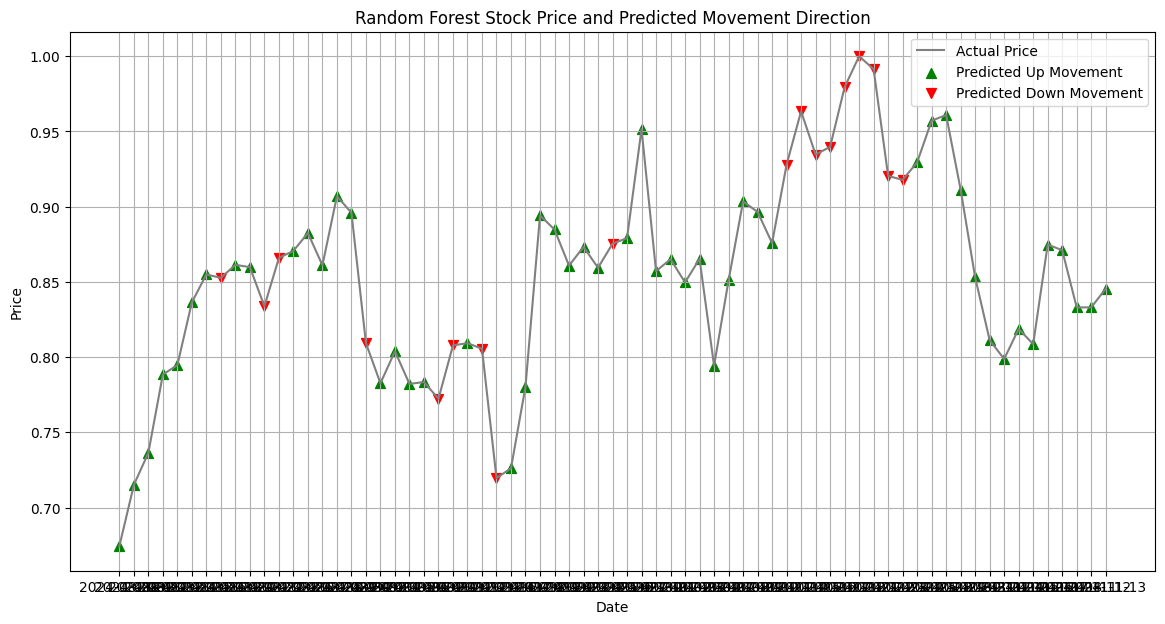

In [37]:
test = stock_news_data[['Date', 'Adj Close']][window_size:][split_point:]
predicted_movements = pd.DataFrame({
    'Date': test['Date'],
    'Predicted_Movement': binary_predictions
})

# Merge predictions with the original price data
results = pd.merge(test, predicted_movements, on='Date', how='left')

plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Adj Close'], label='Actual Price', color='gray')

# Highlight the predicted up and down movements
up_movement = results[results['Predicted_Movement'] == 1]
down_movement = results[results['Predicted_Movement'] == 0]

plt.scatter(up_movement['Date'], up_movement['Adj Close'], color='green', label='Predicted Up Movement', marker='^', s=50)
plt.scatter(down_movement['Date'], down_movement['Adj Close'], color='red', label='Predicted Down Movement', marker='v', s=50)

plt.title('Random Forest Stock Price and Predicted Movement Direction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()